In [50]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import scipy.stats as sps
import statsmodels.api as sm

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec

import radical.utils as ru
import radical.pilot as rp
import radical.analytics as ra

from IPython.display import display
from scipy.stats import linregress

pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_rows', 50)

# Global configurations
# ---------------------

# Use LaTeX and its body font for the diagrams' text.
mpl.rcParams['text.usetex'] = True 
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif']  = ['Nimbus Roman Becker No9L']

# Font sizes
SIZE = 12
plt.rc('font', size=SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)  # fontsize of the x any y labels
plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE-2)  # legend fontsize
plt.rc('figure', titlesize=SIZE)  # # size of the figure title

# Use thinner lines for axes to avoid distractions.
mpl.rcParams['axes.linewidth']    = 0.75
mpl.rcParams['xtick.major.width'] = 0.75
mpl.rcParams['xtick.minor.width'] = 0.75
mpl.rcParams['ytick.major.width'] = 0.75
mpl.rcParams['ytick.minor.width'] = 0.75

# Do not use a box for the legend to avoid distractions.
mpl.rcParams['legend.frameon'] = False

# Helpers
# -------

# Use coordinated colors. These are the "Tableau 20" colors as 
# RGB. Each pair is strong/light. For a theory of color    
tableau20 = [(31 , 119, 180), (174, 199, 232), # blue        [ 0,1 ]
             (255, 127, 14 ), (255, 187, 120), # orange      [ 2,3 ]
             (44 , 160, 44 ), (152, 223, 138), # green       [ 4,5 ]
             (214, 39 , 40 ), (255, 152, 150), # red         [ 6,7 ]
             (148, 103, 189), (197, 176, 213), # purple      [ 8,9 ]
             (140, 86 , 75 ), (196, 156, 148), # brown       [10,11]
             (227, 119, 194), (247, 182, 210), # pink        [12,13]
             (188, 189, 34 ), (219, 219, 141), # yellow      [14,15]
             (23 , 190, 207), (158, 218, 229), # cyan        [16,17]
             (65 , 68 , 81 ), (96 , 99 , 106), # gray        [18,19]
             (127, 127, 127), (143, 135, 130), # gray        [20,21] 
             (165, 172, 175), (199, 199, 199), # gray        [22,23]
             (207, 207, 207)]                   # gray        [24]
  
# Scale the RGB values to the [0, 1] range, which is the format 
# matplotlib accepts.    
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)    

# Return a single plot without right and top axes
def fig_setup():
    fig = plt.figure(figsize=(13,7))
    ax = fig.add_subplot(111)  
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)  
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    
    return fig, ax



# Synapse

In [51]:
baseline = pd.read_csv('../../synapse_characterization/sander_run_radical/sander_run_radical.csv', 
                        header=None, 
                        usecols=[3],
                        names = ['TTC'])

profiler = pd.read_csv('../../synapse_characterization/sander_profile_radical/sander_profile_radical.csv', 
                        header=None, 
                        usecols=[3,4],
                        names = ['Profiled TTC','Number of FLOPS'])

emulation_mean = pd.read_csv('../../synapse_characterization/sample_mean_flops_radical/sander_emulate_meanflops_radical.csv', 
                        header=None, 
                        usecols=[3],
                        names = ['Emulated TTC'])

emulation = pd.read_csv('../../synapse_characterization/sample_flops_radical/sander_emulate_flops_radical.csv', 
                        header=None, 
                        usecols=[3],
                        names = ['Emulated TTC'])

emulation_prof = pd.read_csv('../../synapse_characterization/sample_profiles_radical/sander_emulate_profiles_radical.csv', 
                        header=None, 
                        usecols=[3],
                        names = ['Emulated TTC'])

NormaltestResult(statistic=10.747893904038325, pvalue=0.0046357978816926985)

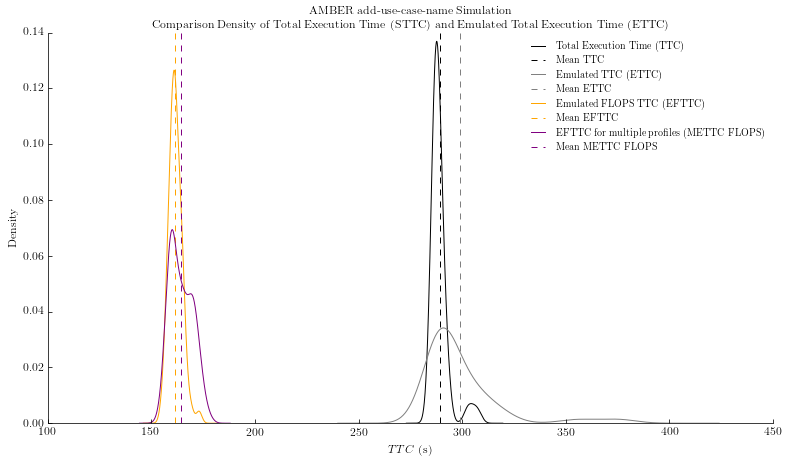

In [52]:
fig, ax = fig_setup()
title='AMBER add-use-case-name Simulation\nComparison Density of Total Execution Time (STTC) and Emulated Total Execution Time (ETTC)'#\nNote: Tail truncated at 2000s.'

display(sps.normaltest(emulation_mean['Emulated TTC'].dropna().tolist()))

# TTC
baseline[['TTC']].dropna().reset_index(drop=True).plot.density(ax=ax, color='black', title=title)
plt.axvline(baseline['TTC'].dropna().mean(), color='black', linestyle='dashed', linewidth=1)

# Emulated FLOPS+I/O TTC
emulation_prof[['Emulated TTC']].dropna().reset_index(drop=True).plot.density(ax=ax, color='gray', title=title)
plt.axvline(emulation_prof['Emulated TTC'].dropna().mean(), color='gray', linestyle='dashed', linewidth=1)

# Emulated FLOPS TTC
emulation_mean[['Emulated TTC']].dropna().reset_index(drop=True).plot.density(ax=ax, color='orange', title=title)
plt.axvline(emulation_mean['Emulated TTC'].dropna().mean(), color='orange', linestyle='dashed', linewidth=1)

# Emulated FLOPS TTC for every profile.
emulation[['Emulated TTC']].dropna().reset_index(drop=True).plot.density(ax=ax, color='purple', title=title)
plt.axvline(emulation['Emulated TTC'].dropna().mean(), color='purple', linestyle='dashed', linewidth=1)

ax.set_xlabel('$TTC$ (s)')
ax.legend(labels=['Total Execution Time (TTC)', 'Mean TTC',
                  'Emulated TTC (ETTC)', 'Mean ETTC',
                  'Emulated FLOPS TTC (EFTTC)', 'Mean EFTTC',
                  'EFTTC for multiple profiles (METTC FLOPS)', 'Mean METTC FLOPS'])
          #loc='upper center')
    
plt.savefig('figures/synapse_all.pdf', dpi=600, bbox_inches='tight')

# Total number of runs, pilots, units executed/requested

In [53]:
# Load wrangled data saved in .csv files.
sessions = pd.read_csv('data/sessions.csv', index_col=0)
pilots = pd.read_csv('data/pilots.csv', index_col=0)
units = pd.read_csv('data/units.csv', index_col=0)

# Drop experiments with at least 8 tasks but less than 8 pilots.
sessions = sessions[sessions.experiment != 'exp1']
pilots = pilots[pilots.experiment != 'exp1']
units = units[units.experiment != 'exp1']
sessions = sessions[sessions.experiment != 'exp2']
pilots = pilots[pilots.experiment != 'exp2']
units = units[units.experiment != 'exp2']
sessions = sessions[sessions.experiment != 'exp3']
pilots = pilots[pilots.experiment != 'exp3']
units = units[units.experiment != 'exp3']

# Check for spurious data due to bugs and drop them
sessions = sessions.drop(['rp.session.radical.mturilli.017128.0000', 
                          'rp.session.radical.mturilli.017139.0003',
                          'rp.session.radical.mturilli.017131.0005',  # Crazy Tq
                          'rp.session.radical.mturilli.017212.0011',  # inconsistency in concurrency
                          'rp.session.radical.mturilli.017223.0000',  # inconsistency in concurrency
                          'rp.session.radical.mturilli.017228.0001',  # inconsistency in concurrency
                          'rp.session.radical.mturilli.017229.0003']) # inconsistency in concurrency 

pilots = pilots[pilots.sid != 'rp.session.radical.mturilli.017139.0003']
pilots = pilots[pilots.sid != 'rp.session.radical.mturilli.017128.0000']
pilots = pilots[pilots.sid != 'rp.session.radical.mturilli.017131.0005']
pilots = pilots[pilots.sid != 'rp.session.radical.mturilli.017212.0011']
pilots = pilots[pilots.sid != 'rp.session.radical.mturilli.017223.0000']
pilots = pilots[pilots.sid != 'rp.session.radical.mturilli.017228.0001']
pilots = pilots[pilots.sid != 'rp.session.radical.mturilli.017229.0003']

units = units[units.sid != 'rp.session.radical.mturilli.017139.0003']
units = units[units.sid != 'rp.session.radical.mturilli.017128.0000']
units = units[units.sid != 'rp.session.radical.mturilli.017131.0005']
units = units[units.sid != 'rp.session.radical.mturilli.017212.0011']
units = units[units.sid != 'rp.session.radical.mturilli.017223.0000']
units = units[units.sid != 'rp.session.radical.mturilli.017228.0001']
units = units[units.sid != 'rp.session.radical.mturilli.017229.0003']

# Derive number of units requested and number of units 
# rescheduled due to pilot halted/migrated by condor
sessions.loc[(sessions['nunit'] >= 8   ) & (sessions['nunit'] < 16  ), 'nunit_requested'] = 8
sessions.loc[(sessions['nunit'] >= 16  ) & (sessions['nunit'] < 32  ), 'nunit_requested'] = 16
sessions.loc[(sessions['nunit'] >= 32  ) & (sessions['nunit'] < 64  ), 'nunit_requested'] = 32
sessions.loc[(sessions['nunit'] >= 64  ) & (sessions['nunit'] < 128 ), 'nunit_requested'] = 64
sessions.loc[(sessions['nunit'] >= 128 ) & (sessions['nunit'] < 256 ), 'nunit_requested'] = 128
sessions.loc[(sessions['nunit'] >= 256 ) & (sessions['nunit'] < 512 ), 'nunit_requested'] = 256
sessions.loc[(sessions['nunit'] >= 512 ) & (sessions['nunit'] < 1024), 'nunit_requested'] = 512
sessions.loc[(sessions['nunit'] >= 1024) & (sessions['nunit'] < 2048), 'nunit_requested'] = 1024
sessions.loc[(sessions['nunit'] >= 2048) & (sessions['nunit'] < 4096), 'nunit_requested'] = 2048

sessions['nunit_rescheduled'] = sessions['nunit'] - sessions['nunit_requested']

# Drop runs with nunit_requested < npilot
runs = sessions[sessions.nunit_requested < sessions.npilot]['sid'].tolist()
sessions = sessions[sessions.nunit_requested >= sessions.npilot]
for run in runs:
    pilots = pilots[pilots.sid != run]
    units = units[units.sid != run]

In [54]:
print 'Number of successful runs: %s' % sessions.shape[0]
print 'Number of pilots: %s' % pilots.shape[0]
print 'Number of units: %s' % units.shape[0]

Number of successful runs: 270
Number of pilots: 35640
Number of units: 138381


# Measures of execution

In [55]:
ttc = sessions[
    ['npilot','TTC','nunit_requested']].groupby(
        ['npilot','nunit_requested']).aggregate(
            {'TTC':{'TTC_mean':'mean','TTC_std':'std'}})
ttc.columns = ttc.columns.droplevel(0)
ttc = ttc.reset_index()

ttx = sessions[
    ['npilot','U_AGENT_EXECUTING','nunit_requested']].groupby(
        ['npilot','nunit_requested']).aggregate(
            {'U_AGENT_EXECUTING':{'TTX_mean':'mean','TTX_std':'std'}})
ttx.columns = ttx.columns.droplevel(0)
ttx = ttx.reset_index()

ttq = sessions[
    ['npilot','P_LRMS_QUEUING','nunit_requested']].groupby(
        ['npilot','nunit_requested']).aggregate(
            {'P_LRMS_QUEUING':{'TTQ_mean':'mean','TTQ_std':'std'}})
ttq.columns = ttq.columns.droplevel(0)
ttq = ttq.reset_index()

## Total time taken by each run to complete (TTC)

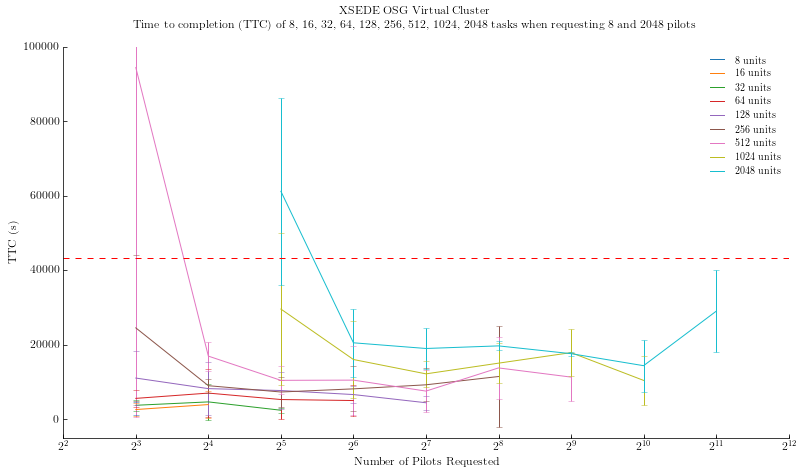

In [56]:
fig, ax = fig_setup()

colors=[tableau20[0] , tableau20[2] , tableau20[4] , tableau20[6] , 
        tableau20[8] , tableau20[10], tableau20[12], tableau20[14], 
        tableau20[16], tableau20[18], tableau20[20], tableau20[1] ,
        tableau20[3] , tableau20[5] , tableau20[7] , tableau20[9] ,
        tableau20[11], tableau20[13], tableau20[15], tableau20[17],
        tableau20[19]]

title_head = 'XSEDE OSG Virtual Cluster'
title_desc = 'Time to completion (TTC) of 8, 16, 32, 64, 128, 256, 512, 1024, 2048 tasks when requesting 8 and 2048 pilots'
title = '%s\n%s' % (title_head, title_desc)
fig.suptitle(title)

nus = ttc['nunit_requested'].unique()
nus.sort()

for nu in nus:
    color = colors.pop(0)
    ttc.loc[ttc['nunit_requested']==nu].plot(x='npilot', y='TTC_mean', yerr='TTC_std', 
                                             label=str(int(nu))+' units',
                                             color=color,
                                             ax=ax)
    
plt.axhline(43200, color='r', linestyle='dashed', linewidth=1, label='12 hours')

ax.set_xscale('log', basex=2)
ax.set_xlim(2**2, 2**12)
ax.set_ylim(-5000, 100000)
ax.set_xlabel('Number of Pilots Requested')
ax.set_ylabel('TTC (s)')

plt.savefig('figures/osg_ttc_all.pdf', dpi=600, bbox_inches='tight')

## Total time spent by all tasks of each run to execute (TTX)

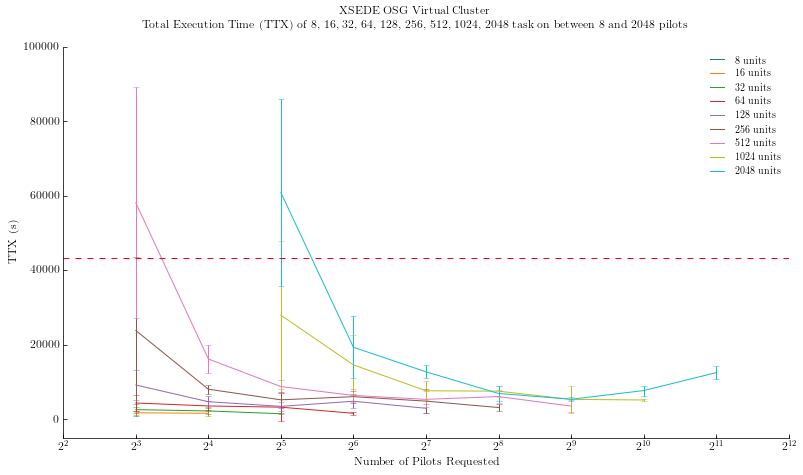

In [57]:
fig, ax = fig_setup()

colors=[tableau20[0] , tableau20[2] , tableau20[4] , tableau20[6] , 
        tableau20[8] , tableau20[10], tableau20[12], tableau20[14], 
        tableau20[16], tableau20[18], tableau20[20], tableau20[1] ,
        tableau20[3] , tableau20[5] , tableau20[7] , tableau20[9] ,
        tableau20[11], tableau20[13], tableau20[15], tableau20[17],
        tableau20[19]]

title_head = 'XSEDE OSG Virtual Cluster'
title_desc = 'Total Execution Time (TTX) of 8, 16, 32, 64, 128, 256, 512, 1024, 2048 task on between 8 and 2048 pilots'
title = '%s\n%s' % (title_head, title_desc)
fig.suptitle(title)


nus = ttc['nunit_requested'].unique()
nus.sort()

for nu in nus:
    ttx.loc[ttx['nunit_requested']==nu].plot(x='npilot', y='TTX_mean', yerr='TTX_std', 
                                             label=str(int(nu))+' units',
                                             color=colors.pop(0),
                                             ax=ax)

plt.axhline(43200, color='r', linestyle='dashed', linewidth=1, label='12 hours')

ax.set_xscale('log', basex=2)
ax.set_xlim(2**2, 2**12)
ax.set_ylim(-5000, 100000)
ax.set_xlabel('Number of Pilots Requested')
ax.set_ylabel('TTX (s)')

plt.savefig('figures/osg_ttx_all.pdf', dpi=600, bbox_inches='tight')

## Total time spent by the pilots of each run waiting in a queue (TTQ)

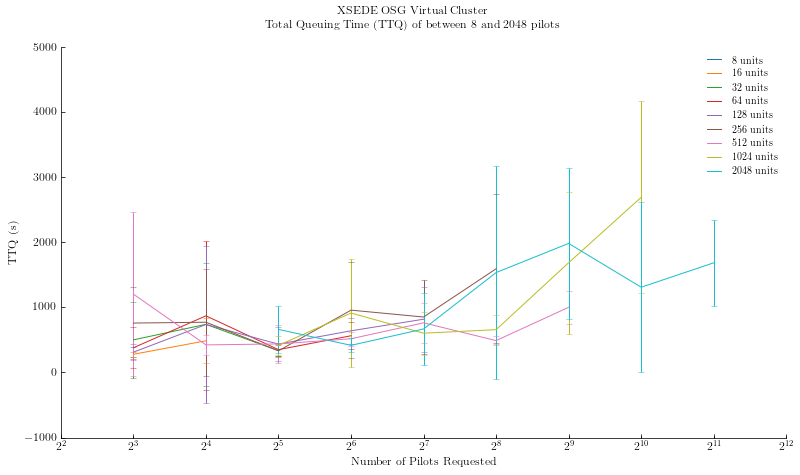

In [58]:
fig, ax = fig_setup()

colors=[tableau20[0] , tableau20[2] , tableau20[4] , tableau20[6] , 
        tableau20[8] , tableau20[10], tableau20[12], tableau20[14], 
        tableau20[16], tableau20[18], tableau20[20], tableau20[1] ,
        tableau20[3] , tableau20[5] , tableau20[7] , tableau20[9] ,
        tableau20[11], tableau20[13], tableau20[15], tableau20[17],
        tableau20[19]]

title_head = 'XSEDE OSG Virtual Cluster'
title_desc = 'Total Queuing Time (TTQ) of between 8 and 2048 pilots'
title = '%s\n%s' % (title_head, title_desc)
fig.suptitle(title)
    
nus = ttq['nunit_requested'].unique()
nus.sort()

for nu in nus:
    ttq.loc[ttq['nunit_requested']==nu].plot(x='npilot', y='TTQ_mean', yerr='TTQ_std', 
                                             label=str(int(nu))+' units',
                                             color=colors.pop(0),
                                             ax=ax)

ax.set_xscale('log', basex=2)
ax.set_xlim(2**2, 2**12)
ax.set_xlabel('Number of Pilots Requested')
ax.set_ylabel('TTQ (s)')

plt.savefig('figures/osg_ttq_all.pdf', dpi=600, bbox_inches='tight')

# Measures of heterogeneity and dynamicity

## Resources

### Total number of resources used across all runs

In [59]:
len(units['hid'].unique().tolist())

32

### Distribution of the number of resources across all runs

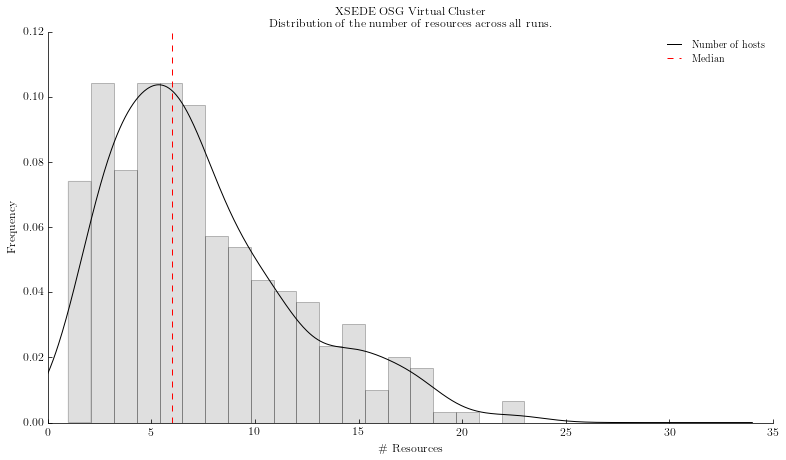

In [60]:
fig, ax = fig_setup()

title='XSEDE OSG Virtual Cluster\nDistribution of the number of resources across all runs.'

sessions[['nhost']].dropna().reset_index(drop=True).plot.density(ax=ax, 
                                                                 color='black', 
                                                                 title=title)
sessions[['nhost']].dropna().reset_index(drop=True).plot.hist(
                ax=ax, 
                color='gray', 
                bins=20, 
                alpha = 0.25,
                normed=True)
plt.axvline(sessions['nhost'].dropna().median(), color='r', linestyle='dashed', linewidth=1)

ax.legend(labels=['Number of hosts', 'Median'])
plt.xlabel('\# Resources')
ax.set_xlim(0)

plt.savefig('figures/osg_dstrb_nresources_all.pdf', dpi=600, bbox_inches='tight')

### Distribution of the number of resources per number of pilots requested (= number of jobs submitted)

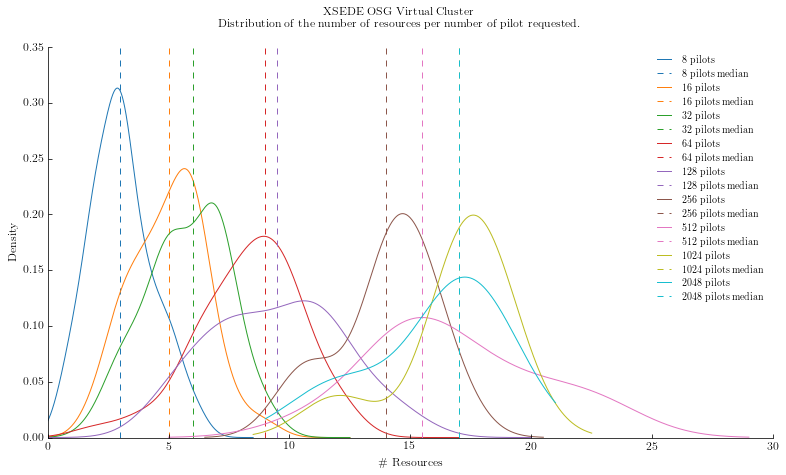

In [61]:
fig, ax = fig_setup()

colors=[tableau20[0] , tableau20[2] , tableau20[4] , tableau20[6] , 
        tableau20[8] , tableau20[10], tableau20[12], tableau20[14], 
        tableau20[16], tableau20[18], tableau20[20], tableau20[1] ,
        tableau20[3] , tableau20[5] , tableau20[7] , tableau20[9] ,
        tableau20[11], tableau20[13], tableau20[15], tableau20[17],
        tableau20[19]]

title='XSEDE OSG Virtual Cluster\nDistribution of the number of resources per number of pilot requested.'
fig.suptitle(title)

nrpilots = sorted(sessions['npilot'].dropna().unique().tolist())

for nrpilot in nrpilots:
    color = colors.pop(0)
    nhosts = sessions[sessions['npilot'] == nrpilot][['nhost']].dropna()
    nhosts.reset_index(drop=True).rename(index=str, columns={"nhost": str(int(nrpilot))+' pilots'}).plot.density(
                ax=ax,
                color=color,)
#                 legend=False)
#     nhosts.reset_index(drop=True).rename(index=str, columns={"nhost": str(int(nrpilot))+' pilots'}).plot.hist(
#                 ax=ax, 
#                 color=color, 
#                 bins=20, 
#                 alpha = 0.25,
#                 normed=True,
#                 legend=True)
    plt.axvline(nhosts['nhost'].median(), 
                color=color, 
                linestyle='dashed', 
                linewidth=1, 
                label=str(int(nrpilot))+' pilots median')

plt.legend()
plt.xlabel('\# Resources')
ax.set_xlim(0)

plt.savefig('figures/osg_dstrb_nresources_x_npilots.pdf', dpi=600, bbox_inches='tight')

### $T_r$ per resource

(0, 50000.0)

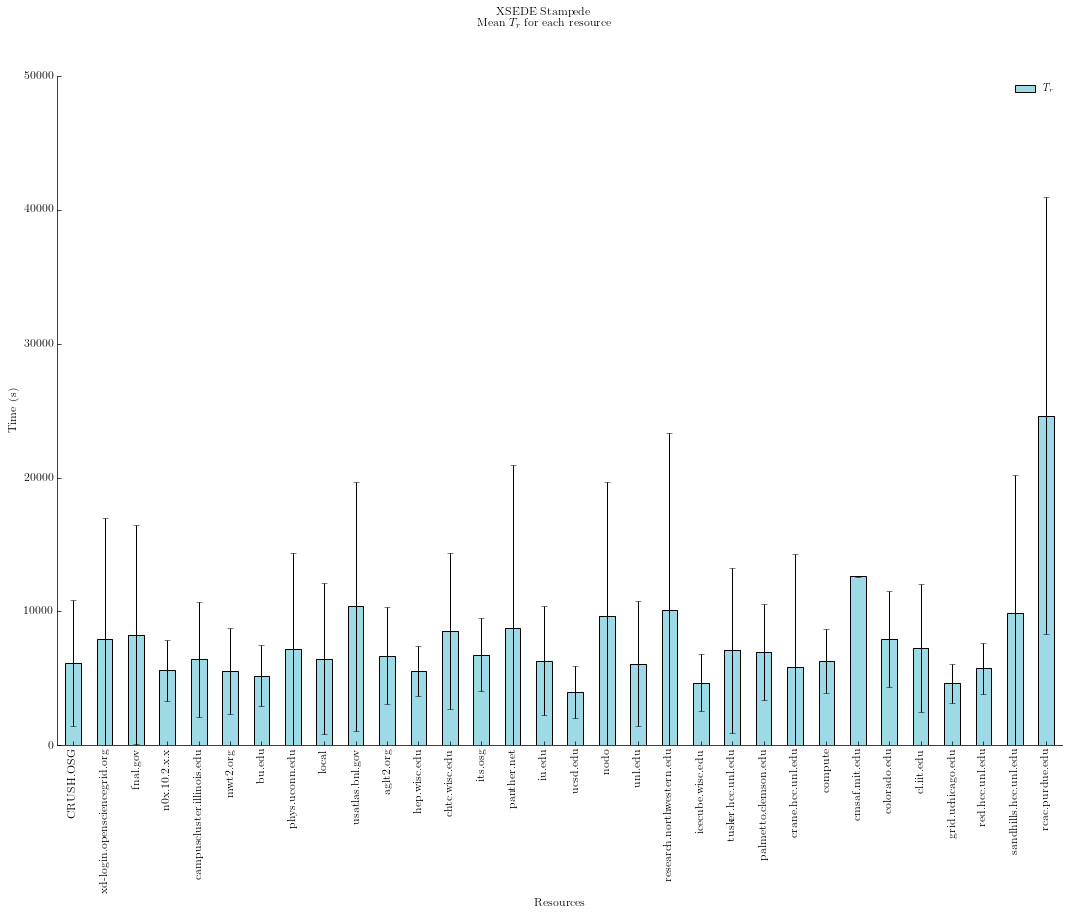

In [62]:
fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()
    
title_head = 'XSEDE Stampede'
title_desc = 'Mean $T_r$ for each resource'
title = '%s\n%s' % (title_head, title_desc)
fig.suptitle(title)

# Get mean and std Tq and Tr for every resource
pg = pilots[['hid','P_LRMS_RUNNING']].dropna().groupby(['hid'])
means = pg.aggregate({'P_LRMS_RUNNING':{'$T_r$':'mean'}})
errs = pg.aggregate( {'P_LRMS_RUNNING':{'$T_r$':'std'}})

# Concatenate Tq, Tr, Tx and cleanup DF headers
means.columns = means.columns.droplevel(0)
errs.columns = errs.columns.droplevel(0)

# Get the top 15 resources for number of run pilots
hsorted = pilots.loc[pilots['P_LRMS_QUEUING']>1][['hid', 'pid']].groupby('hid').count().sort_values(by='pid', ascending=False).index.tolist()

# Plot means and std bars for the top 15 resources
means.ix[hsorted].plot(y='$T_r$', yerr=errs.ix[hsorted],
           color=tableau20[17],
           ax=ax,
           kind='bar')

ax.set_xlabel('Resources')
ax.set_ylabel('Time (s)')
#ax.set_yscale('log', basex=2)
ax.set_ylim(0)

### $T_x$ per resource

(0, 3500.0)

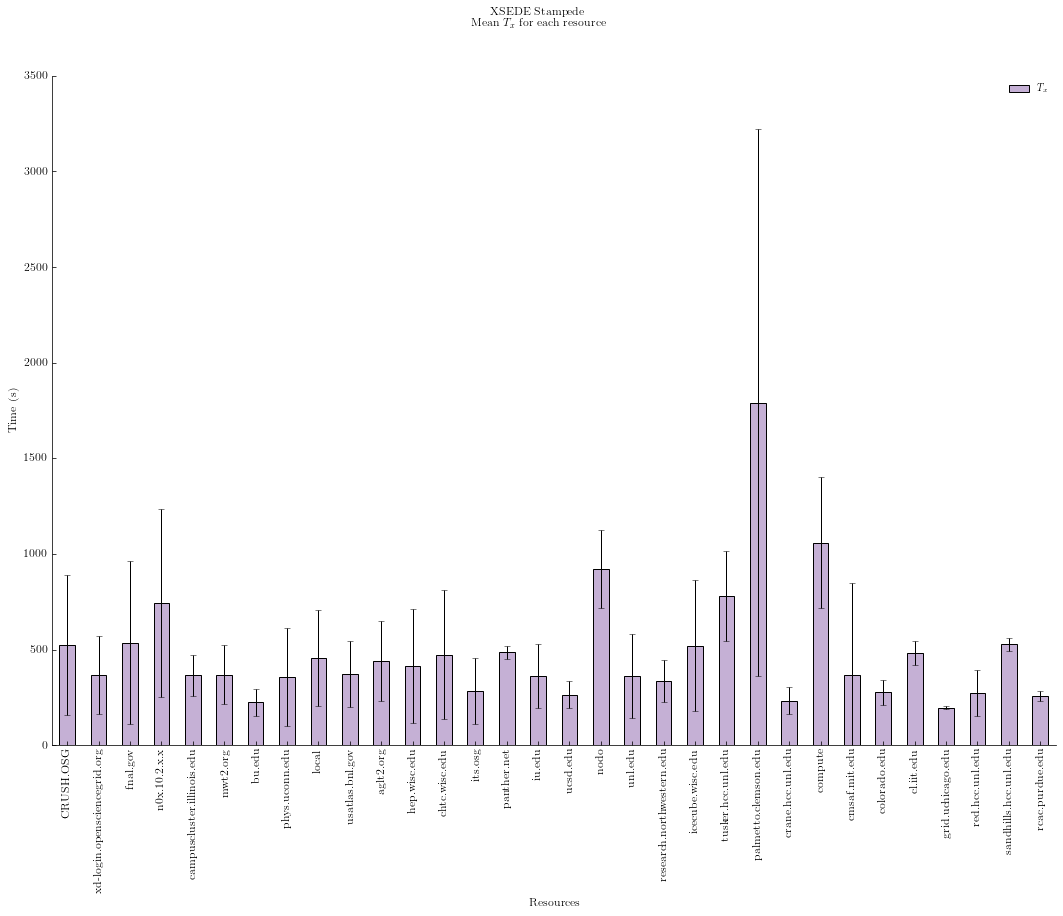

In [63]:
fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()
    
title_head = 'XSEDE Stampede'
title_desc = 'Mean $T_x$ for each resource'
title = '%s\n%s' % (title_head, title_desc)
fig.suptitle(title)

# Get mean and std Tx for every resource
ug = units[['hid','U_AGENT_EXECUTING']].dropna().groupby(['hid']) 
means = ug.aggregate({'U_AGENT_EXECUTING':{'$T_x$':'mean'}})
errs = ug.aggregate({'U_AGENT_EXECUTING':{'$T_x$':'std'}})

# Concatenate Tq, Tr, Tx and cleanup DF headers
means.columns = means.columns.droplevel(0)
errs.columns = errs.columns.droplevel(0)

# Get the top 15 resources for number of run pilots
hsorted = pilots.loc[pilots['P_LRMS_QUEUING']>1][['hid', 'pid']].groupby('hid').count().sort_values(by='pid', ascending=False).index.tolist()

# Plot means and std bars for the top 15 resources
means.ix[hsorted].plot(y='$T_x$', yerr=errs.ix[hsorted],
           color=tableau20[9],
           ax=ax,
           kind='bar')

ax.set_xlabel('Resources')
ax.set_ylabel('Time (s)')
#ax.set_yscale('log', basex=2)
ax.set_ylim(0)

### $T_q$ per resource

(0, 1400.0)

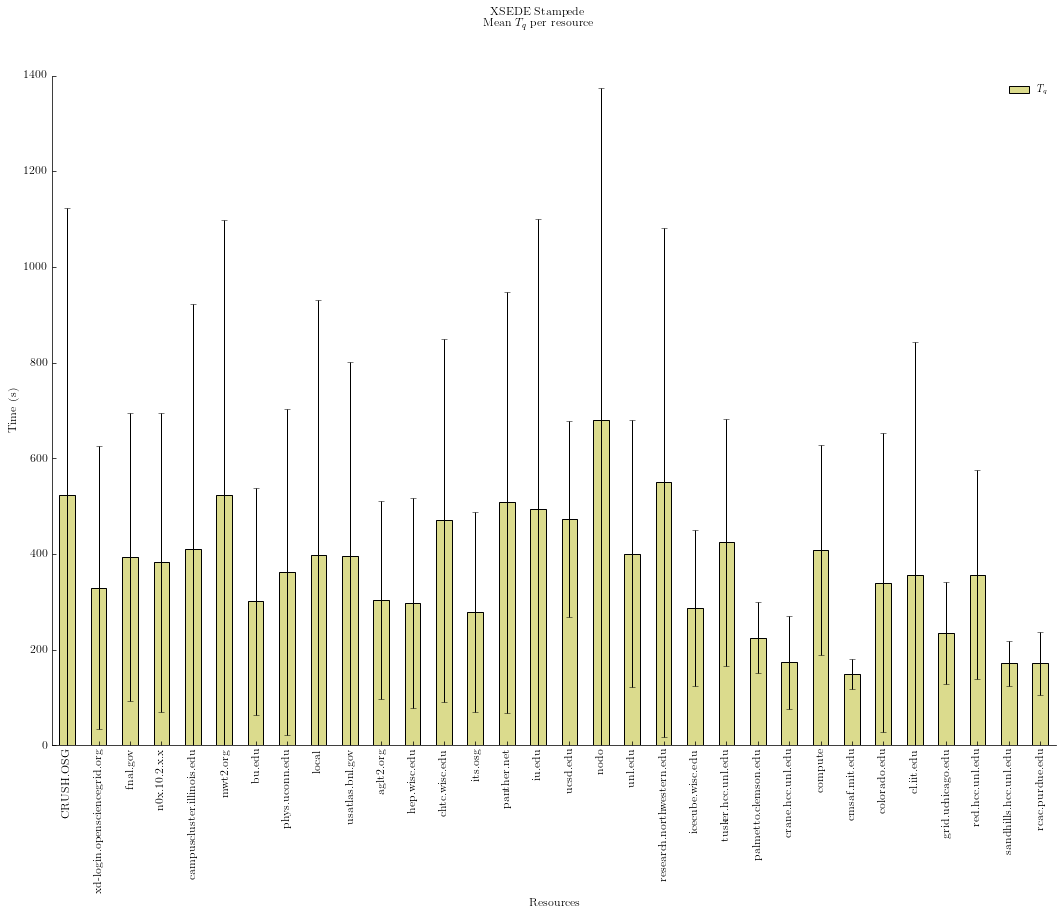

In [64]:
fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()
    
title_head = 'XSEDE Stampede'
title_desc = 'Mean $T_q$ per resource'
title = '%s\n%s' % (title_head, title_desc)
fig.suptitle(title)

# Get mean and std Tq and Tr for every resource
pg = pilots[pilots['P_LRMS_QUEUING']>1][['hid','P_LRMS_QUEUING']].dropna().groupby(['hid'])
means = pg.aggregate({'P_LRMS_QUEUING':{'$T_q$':'mean'}})
errs = pg.aggregate( {'P_LRMS_QUEUING':{'$T_q$':'std'} })

# Cleanup DF headers
means.columns = means.columns.droplevel(0)
errs.columns = errs.columns.droplevel(0)

# Sorted husts by number of queued pilots
hsorted = pilots.loc[pilots['P_LRMS_QUEUING']>1][['hid', 'pid']].groupby('hid').count().sort_values(by='pid', ascending=False).index.tolist()

# Plot means and std bars for the top 15 resources
means.ix[hsorted].plot(y='$T_q$', yerr=errs.ix[hsorted],
           color=tableau20[15],
           ax=ax,
           kind='bar')

ax.set_xlabel('Resources')
ax.set_ylabel('Time (s)')
#ax.set_yscale('log', basex=2)
ax.set_ylim(0)

### $T_q$, $T_r$, $T_x$ for the 15 most used resources (number of pilots and tasks executed)

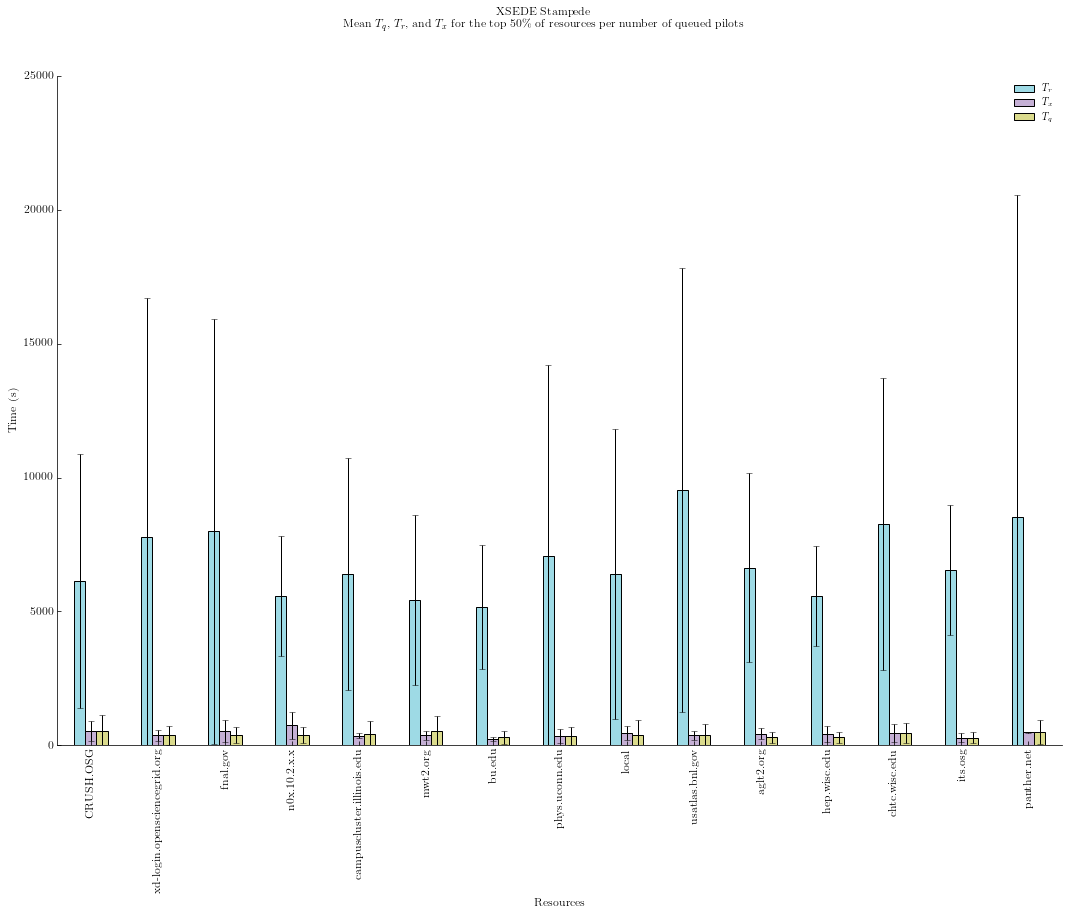

In [65]:
fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()
    
title_head = 'XSEDE Stampede'
title_desc = 'Mean $T_q$, $T_r$, and $T_x$ for the top 50\% of resources per number of queued pilots'
title = '%s\n%s' % (title_head, title_desc)
fig.suptitle(title)

# Get mean and std Tq and Tr for every resource
pg = pilots[pilots['P_LRMS_QUEUING']>1][['hid','P_LRMS_QUEUING','P_LRMS_RUNNING']].dropna().groupby(['hid'])
pmeans = pg.aggregate({'P_LRMS_RUNNING':{'$T_r$':'mean'}, 'P_LRMS_QUEUING':{'$T_q$':'mean'}})
perrs = pg.aggregate( {'P_LRMS_RUNNING':{'$T_r$':'std'} , 'P_LRMS_QUEUING':{'$T_q$':'std'} })

# Get mean and std Tx for every resource
ug = units[['hid','U_AGENT_EXECUTING']].dropna().groupby(['hid']) 
umeans = ug.aggregate({'U_AGENT_EXECUTING':{'$T_x$':'mean'}})
uerrs = ug.aggregate({'U_AGENT_EXECUTING':{'$T_x$':'std'}})

# Concatenate Tq, Tr, Tx and cleanup DF headers
means = pd.concat([pmeans,umeans], axis=1, join_axes=[pmeans.index])
errs = pd.concat([perrs,uerrs], axis=1, join_axes=[perrs.index])
means.columns = means.columns.droplevel(0)
errs.columns = errs.columns.droplevel(0)

# Get the top 15 resources for number of run pilots
dft15 = pilots.loc[pilots['P_LRMS_QUEUING']>1][['hid', 'pid']].groupby('hid').count().sort_values(by='pid', ascending=False).head(n=15)
t15 = dft15.index.tolist()

# Plot means and std bars for the top 15 resources
means.ix[t15].plot(y=['$T_r$','$T_x$','$T_q$'], yerr=errs.ix[t15],
           color=[tableau20[17],tableau20[9], tableau20[15]],
           ax=ax,
           kind='bar')

ax.set_xlabel('Resources')
ax.set_ylabel('Time (s)')
#ax.set_yscale('log', basex=2)
ax.set_ylim(0)

plt.savefig('figures/osg_trtxtq_x_resources.pdf', dpi=600, bbox_inches='tight')

## Pilots

### Distribution of number of active pilots across all runs

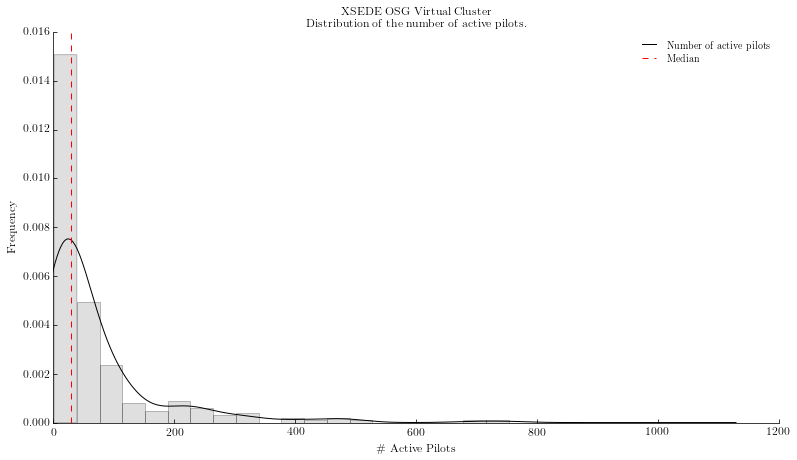

In [66]:
fig, ax = fig_setup()

title='XSEDE OSG Virtual Cluster\nDistribution of the number of active pilots.'

sessions[['npilot_active']].dropna().reset_index(drop=True).plot.density(ax=ax, 
                                                                         color='black', 
                                                                         title=title)
sessions[['npilot_active']].dropna().reset_index(drop=True).plot.hist(
                ax=ax, 
                color='gray', 
                bins=20, 
                alpha = 0.25,
                normed=True)
plt.axvline(sessions['npilot_active'].dropna().median(), color='r', linestyle='dashed', linewidth=1)

ax.legend(labels=['Number of active pilots', 'Median'])
plt.xlabel('\# Active Pilots')
ax.set_xlim(0)

plt.savefig('figures/osg_dstrb_napilots_all.pdf', dpi=600, bbox_inches='tight')

### Distribution of the number of active pilots per number of pilot requested (= number of jobs submitted)

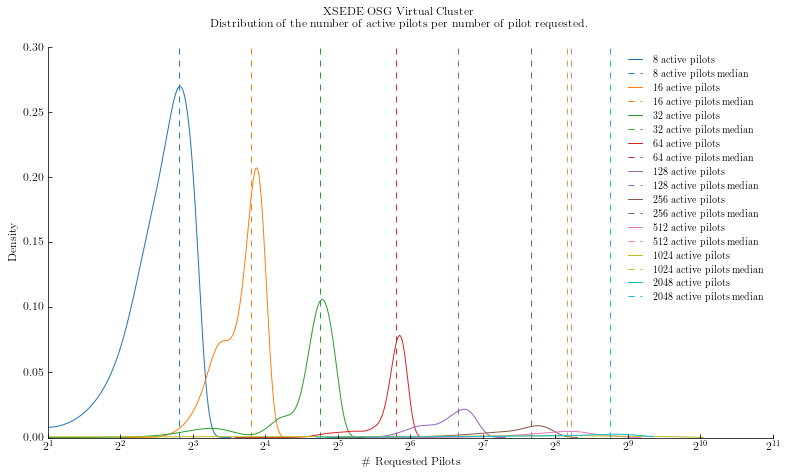

In [67]:
fig, ax = fig_setup()

colors=[tableau20[0] , tableau20[2] , tableau20[4] , tableau20[6] , 
        tableau20[8] , tableau20[10], tableau20[12], tableau20[14], 
        tableau20[16], tableau20[18], tableau20[20], tableau20[1] ,
        tableau20[3] , tableau20[5] , tableau20[7] , tableau20[9] ,
        tableau20[11], tableau20[13], tableau20[15], tableau20[17],
        tableau20[19]]

title='XSEDE OSG Virtual Cluster\nDistribution of the number of active pilots per number of pilot requested.'
fig.suptitle(title)

nrpilots = sorted(sessions['npilot'].dropna().unique().tolist())

display

for nrpilot in nrpilots:
    color = colors.pop(0)
    nhosts = sessions[sessions['npilot'] == nrpilot][['npilot_active']].dropna()
    nhosts.reset_index(drop=True).rename(index=str, columns={"npilot_active": str(int(nrpilot))+' active pilots'}).plot.density(
                ax=ax,
                color=color,)
#                 legend=False)
#     nhosts.reset_index(drop=True).rename(index=str, columns={"npilot_active": str(int(nrpilot))+' active pilots'}).plot.hist(
#                 ax=ax, 
#                 color=color, 
#                 bins=20, 
#                 alpha = 0.25,
#                 normed=True,
#                 legend=True)
    plt.axvline(nhosts['npilot_active'].median(), 
                color=color, 
                linestyle='dashed', 
                linewidth=1, 
                label=str(int(nrpilot))+' active pilots median')

plt.legend()
plt.xlabel('\# Requested Pilots')
ax.set_xlim(2,2**11)
ax.set_xscale('log', basex=2)

plt.savefig('figures/osg_dstrb_napilots_x_nrpilots.pdf', dpi=600, bbox_inches='tight')

### Total number of pilots per resource across all runs

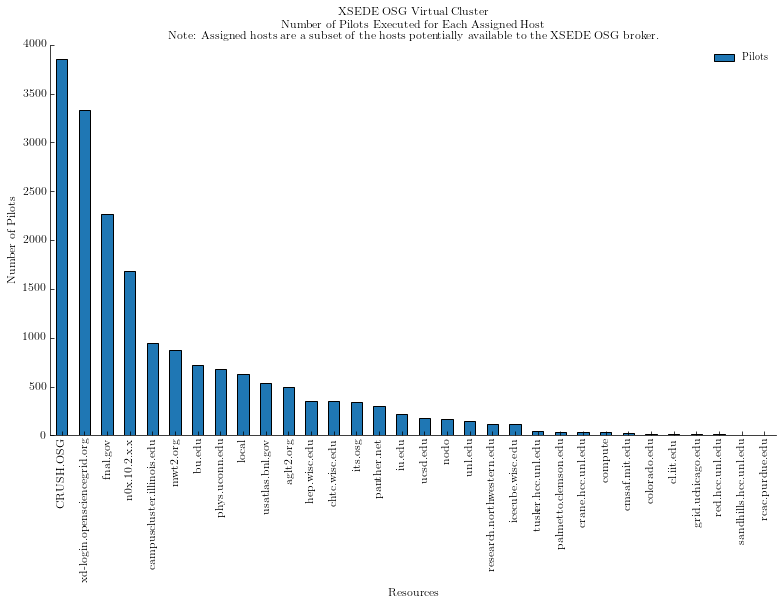

In [68]:
fig, ax = fig_setup()

title='XSEDE OSG Virtual Cluster\nNumber of Pilots Executed for Each Assigned Host\nNote: Assigned hosts are a subset of the hosts potentially available to the XSEDE OSG broker.'

ps = pilots.loc[pilots['P_LRMS_QUEUING']>1]
ps[['hid', 'pid']].groupby('hid').count().sort_values(by='pid', ascending=False).plot.bar(ax=ax, 
                                                                                          color=tableau20[0], 
                                                                                          title=title)

ax.set_xlabel('Resources')
ax.set_ylabel('Number of Pilots')
ax.legend(labels=['Pilots'])

## Distribution of pilot queue waiting time ($T_q$) across all runs

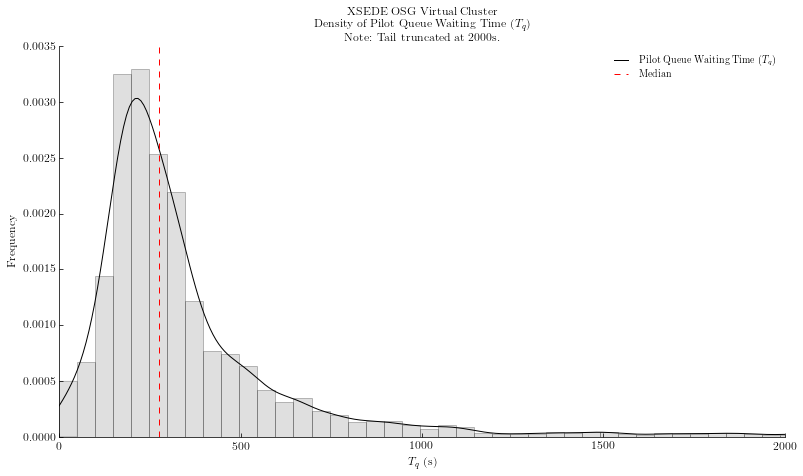

In [69]:
fig, ax = fig_setup()
title='XSEDE OSG Virtual Cluster\nDensity of Pilot Queue Waiting Time ($T_q$)\nNote: Tail truncated at 2000s.'

pilots.loc[pilots['nunit']>1][['P_LRMS_QUEUING']].dropna().reset_index(drop=True).plot.density(ax=ax, 
                                                                                               color='black', 
                                                                                               title=title)
pilots.loc[pilots['nunit']>1][['P_LRMS_QUEUING']].dropna().reset_index(drop=True).plot.hist(ax=ax, 
                                                                       color='gray', 
                                                                       bins=80, 
                                                                       alpha = 0.25,
                                                                       normed=True)
plt.axvline(pilots['P_LRMS_QUEUING'].dropna().median(), color='r', linestyle='dashed', linewidth=1)

ax.legend(labels=['Pilot Queue Waiting Time ($T_q$)', 'Median'])
ax.set_xlim(0, 2000)
ax.set_xlabel('$T_q$ (s)')

plt.savefig('figures/osg_dstrb_tq_all.pdf', dpi=600, bbox_inches='tight')

## Distribution of pilot queue waiting time ($T_q$) across all runs per resource

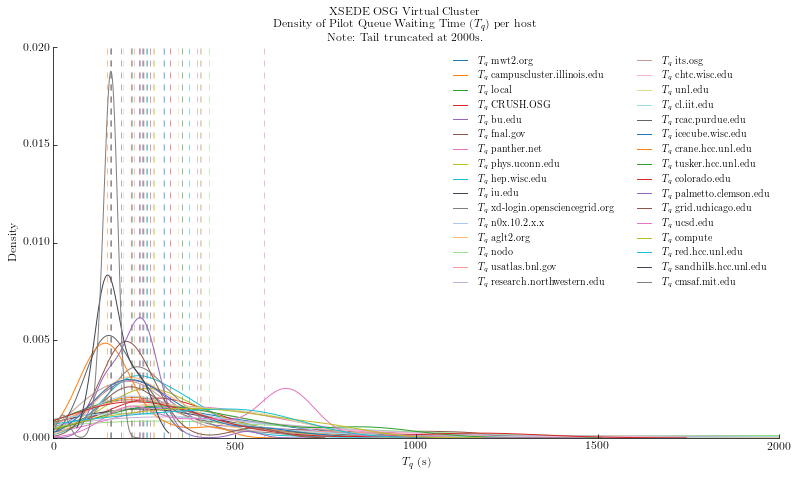

In [70]:
fig, ax = fig_setup()

colors=[tableau20[0] , tableau20[2] , tableau20[4] , tableau20[6] , tableau20[8] , 
        tableau20[10], tableau20[12], tableau20[14], tableau20[16], tableau20[18], 
        tableau20[20], tableau20[1] , tableau20[3] , tableau20[5] , tableau20[7] , 
        tableau20[9] , tableau20[11], tableau20[13], tableau20[15], tableau20[17],
        tableau20[19], tableau20[0] , tableau20[2] , tableau20[4] , tableau20[6] , 
        tableau20[8] , tableau20[10], tableau20[12], tableau20[14], tableau20[16], 
        tableau20[18], tableau20[20], tableau20[1] , tableau20[3] , tableau20[5]]

title='XSEDE OSG Virtual Cluster\nDensity of Pilot Queue Waiting Time ($T_q$) per host\nNote: Tail truncated at 2000s.'
fig.suptitle(title)

hosts = pilots.loc[pilots['P_LRMS_QUEUING']>1]['hid'].dropna().unique()
for host in hosts:
    color = colors.pop(0)
    tqs = pilots.loc[pilots['hid']==host][['P_LRMS_QUEUING']].dropna() 
    tqs.reset_index(drop=True).rename(
                index=str, 
                columns={"P_LRMS_QUEUING": '$T_q$ '+host}).plot.density(ax=ax, color=color)
    plt.axvline(tqs['P_LRMS_QUEUING'].median(), 
                color=color, 
                linestyle='dashed', 
                linewidth=0.5)

ax.legend(ncol=2)
ax.set_xlim(0, 2000)
ax.set_xlabel('$T_q$ (s)')

plt.savefig('figures/osg_dstrb_tq_x_resource.pdf', dpi=600, bbox_inches='tight')

## Distribution of pilot running time ($T_r$) across all runs

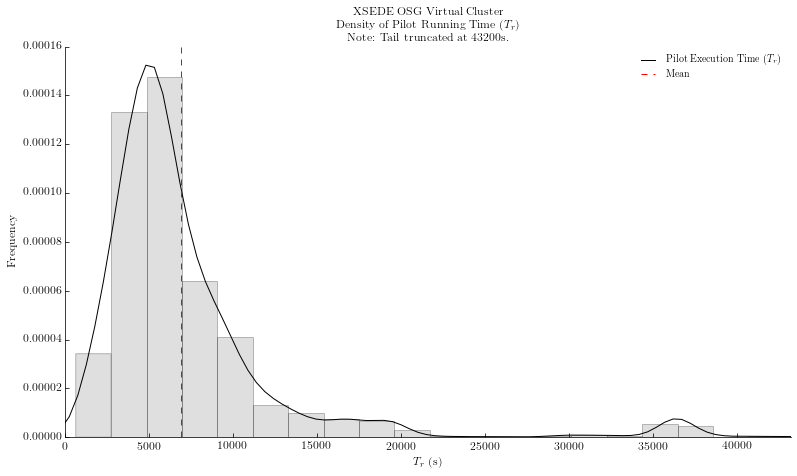

In [71]:
fig, ax = fig_setup()
title='XSEDE OSG Virtual Cluster\nDensity of Pilot Running Time ($T_r$)\nNote: Tail truncated at 43200s.'

pilots.loc[pilots['nunit']>1][['P_LRMS_RUNNING']].dropna().reset_index(drop=True).plot.density(ax=ax, 
                                                                                               color='black', 
                                                                                               title=title)
pilots.loc[pilots['nunit']>1][['P_LRMS_RUNNING']].dropna().reset_index(drop=True).plot.hist(ax=ax, 
                                                                       color='gray', 
                                                                       bins=120, 
                                                                       alpha = 0.25,
                                                                       normed=True)
plt.axvline(pilots['P_LRMS_RUNNING'].dropna().mean(), color='r', linestyle='dashed', linewidth=1)

ax.set_xlim(0, 43200)
ax.set_xlabel('$T_r$ (s)')
ax.legend(labels=['Pilot Execution Time ($T_r$)', 'Mean'])

## Distribution of pilot running time ($T_r$) across all runs per resource

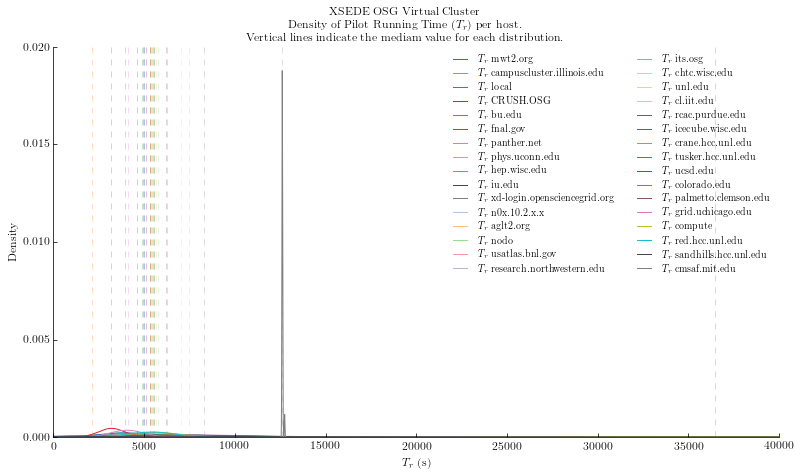

In [72]:
fig, ax = fig_setup()

colors=[tableau20[0] , tableau20[2] , tableau20[4] , tableau20[6] , tableau20[8] , 
        tableau20[10], tableau20[12], tableau20[14], tableau20[16], tableau20[18], 
        tableau20[20], tableau20[1] , tableau20[3] , tableau20[5] , tableau20[7] , 
        tableau20[9] , tableau20[11], tableau20[13], tableau20[15], tableau20[17],
        tableau20[19], tableau20[0] , tableau20[2] , tableau20[4] , tableau20[6] , 
        tableau20[8] , tableau20[10], tableau20[12], tableau20[14], tableau20[16], 
        tableau20[18], tableau20[20], tableau20[1] , tableau20[3] , tableau20[5]]

title='XSEDE OSG Virtual Cluster\nDensity of Pilot Running Time ($T_r$) per host.\nVertical lines indicate the mediam value for each distribution.'
fig.suptitle(title)

hosts = pilots.loc[pilots['P_LRMS_RUNNING']>1]['hid'].dropna().unique()
for host in hosts:
    color = colors.pop(0)
    tqs = pilots.loc[pilots['hid']==host][['P_LRMS_RUNNING']].dropna() 
    tqs.reset_index(drop=True).rename(
                index=str, 
                columns={'P_LRMS_RUNNING': '$T_r$ '+host}).plot.density(ax=ax, color=color)
    plt.axvline(tqs['P_LRMS_RUNNING'].median(), 
                color=color, 
                linestyle='dashed', 
                linewidth=0.5,
                alpha=0.5)

ax.legend(ncol=2)
ax.set_xlim(0,40000)
# ax.set_xlim(0,0.005)
ax.set_xlabel('$T_r$ (s)')

## Correlation number of requested pilots/active pilots across all runs

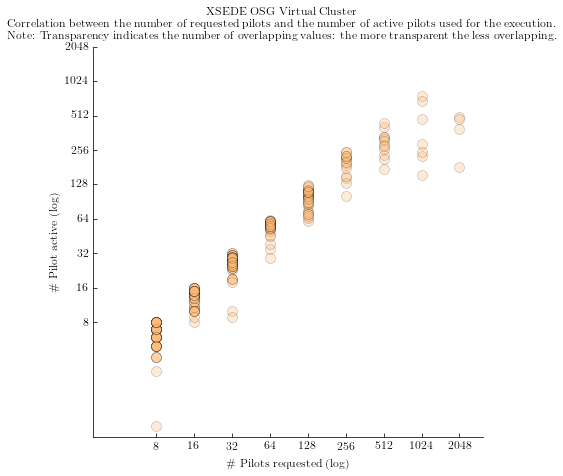

In [73]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()
    
title='XSEDE OSG Virtual Cluster\n'+\
'Correlation between the number of requested pilots and the number of active pilots used for the execution.\n'+\
'Note: Transparency indicates the number of overlapping values: the more transparent the less overlapping.'
fig.suptitle(title)

qui = sessions.rename(columns={'npilot_active':'NpActive'}).copy()
ax.scatter(qui['npilot'], qui['NpActive'], s=100, facecolor=tableau20[3], alpha=0.3, lw=0.5)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((10**0.4, 10**3.5))#-50, 550))
ax.set_ylim((10**-0.1, 10**3.2))

plt.minorticks_off()
plt.xticks([8,16,32,64,128,256,512,1024,2048], [8,16,32,64,128,256,512,1024,2048])
plt.yticks([8,16,32,64,128,256,512,1024,2048], [8,16,32,64,128,256,512,1024,2048])
plt.xlabel('\# Pilots requested (log)')
plt.ylabel('\# Pilot active (log)')

## Correlation number of active pilots/resources across all runs

(0.98847926267281105, 32.0)

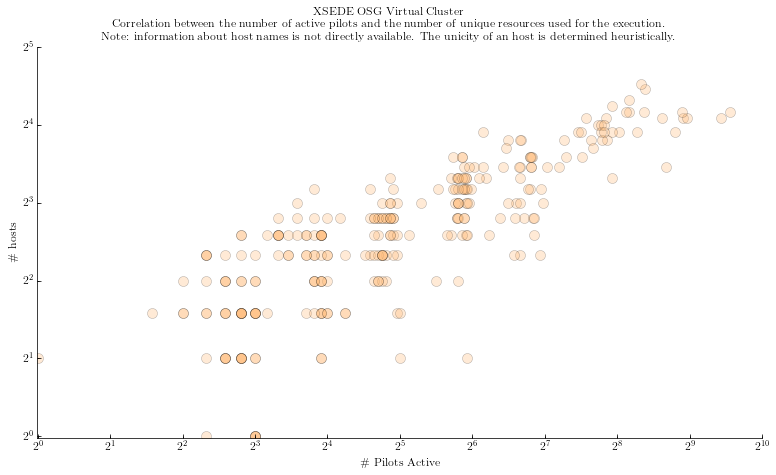

In [74]:
fig, ax = fig_setup()

title='XSEDE OSG Virtual Cluster\n'+\
'Correlation between the number of active pilots and the number of unique resources used for the execution.\n'+\
'Note: information about host names is not directly available. The unicity of an host is determined heuristically.'
fig.suptitle(title)

paperino = sessions.copy()
ax.scatter(paperino['npilot_active'], paperino['nhost'], s=100, alpha=0.3, facecolor=tableau20[3], lw=0.5)

ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)
plt.xlabel('\# Pilots Active')
plt.ylabel('\# hosts')
ax.set_xlim((-10))
ax.set_ylim((0))


### Number of active pilots at runtime across all runs with 2048 tasks and between 32 and 2048 requested pilots

In [26]:
# load ra session objects.
path = '/Users/mturilli/Projects/RADICAL/github/experiments/AIMES-Experience/OSG/analysis/data'

# sessions with 2048 units
snpilots = [32,64,128,256,512,1024,2048]

# load the RA session objects 
sras = {}
for snpilot in snpilots:
    sras[snpilot] = []
    s = sessions[(sessions['nunit_requested'] == 2048) & (sessions['npilot'] == snpilot)]
    for sid in s['sid'].tolist():
        exp = s.ix[sid]['experiment']
        sras[snpilot].append(ra.Session(sid, 'radical.pilot', src='%s/%s/%s' % (path, exp, sid)))

In [75]:
print "Total number of runs with 2048 tasks: %s" % sum([len(sras[x]) for x in sras.keys()])

Total number of runs with 2048 tasks: 33


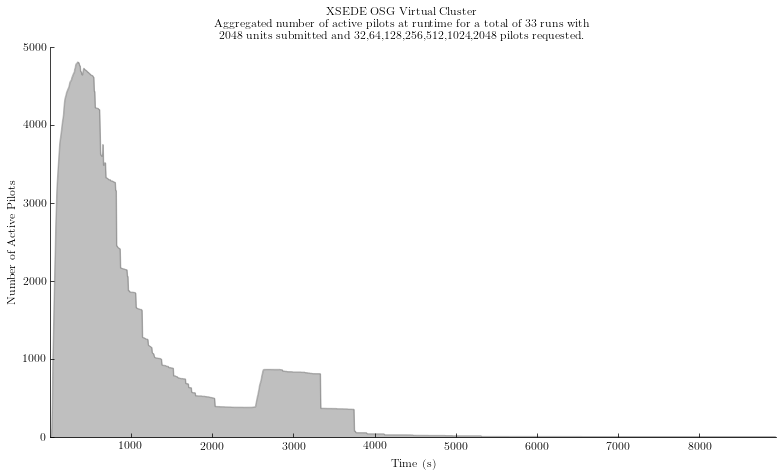

In [76]:
fig, ax = fig_setup()

title='XSEDE OSG Virtual Cluster\n'+\
'Aggregated number of active pilots at runtime for a total of %s runs with\n' % sum([len(sras[x]) for x in sras.keys()])+\
'2048 units submitted and 32,64,128,256,512,1024,2048 pilots requested.'
fig.suptitle(title)

# Use analytics to get a list of list of number of pilots 
# available at every point in time of runtime
ts = []
for s in sorted(sras.keys()):
    for s1 in sras[s]:
        if s1._sid == 'rp.session.radical.mturilli.017131.0005' or \
           s1._sid == 'rp.session.radical.mturilli.017212.0011' or \
           s1._sid == 'rp.session.radical.mturilli.017223.0000' or \
           s1._sid == 'rp.session.radical.mturilli.017228.0001' or \
           s1._sid == 'rp.session.radical.mturilli.017229.0003':
                continue
        sc = s1.concurrency(state=['PMGR_ACTIVE', ['DONE', 'CANCELED', 'FAILED']], sampling=60)
        ts = ts+sc

# Covert list to dataframe. TODO: cleanup and use a pd.series.
ts = sorted(ts, key=lambda x: x[0])
headers = ['timestamp','npilot']
ts = pd.DataFrame(ts, columns=headers)

# Convert number of seconds to a time serie
ts['datetime'] = pd.to_datetime(ts.timestamp, unit='s')
ts.index = ts.datetime
ts.drop(['timestamp','datetime'], axis=1, inplace=True)

# Resample time serie to 1 minute and pad the blanks
# (we downsample so no relevant gaps are expected)
tsmin = ts.resample('1T', label='right', closed='right').sum()
tsminres = tsmin.resample('1T').pad()

# Plot the timesries with numbre of seconds instead of dates
tsminres.index = tsminres.index.astype(np.int64) // 10**10
tsminres.plot.area(ax=ax, color='gray', alpha=0.5, legend=False)

plt.xlabel('Time (s)')
plt.ylabel('Number of Active Pilots')

### Number of active pilots at runtime for every run  with 2048 tasks and between 32 and 2048 requested pilots

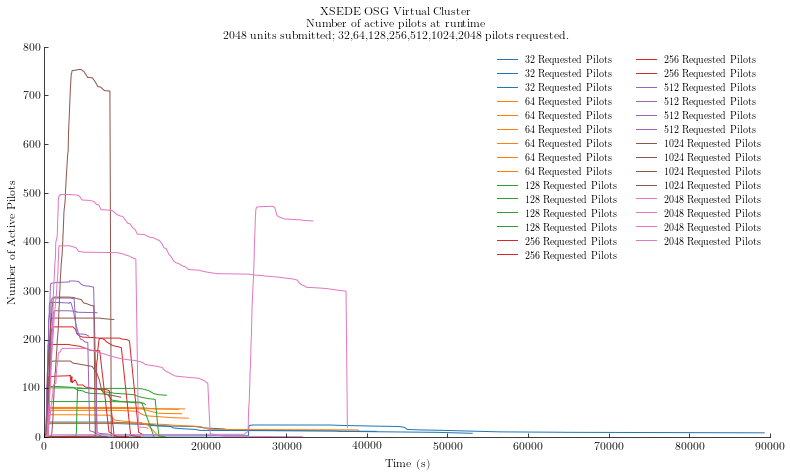

In [77]:
fig, ax = fig_setup()

title='XSEDE OSG Virtual Cluster\n'+\
'Number of active pilots at runtime\n'+\
'2048 units submitted; 32,64,128,256,512,1024,2048 pilots requested.'
fig.suptitle(title)

color = 0
for s in sorted(sras.keys()):
    for s1 in sras[s]:
        # print s1._sid
        # Broken sessions: open ticket.
        if s1._sid == 'rp.session.radical.mturilli.017131.0005' or \
           s1._sid == 'rp.session.radical.mturilli.017212.0011' or \
           s1._sid == 'rp.session.radical.mturilli.017223.0000' or \
           s1._sid == 'rp.session.radical.mturilli.017228.0001' or \
           s1._sid == 'rp.session.radical.mturilli.017229.0003':
                continue        
        sc = s1.concurrency(state=['PMGR_ACTIVE', ['DONE', 'CANCELED', 'FAILED']])
        x = [item[0] for item in sc]
        y = [item[1] for item in sc]
        ax.plot(x, y, color=tableau20[color], label='%s Requested Pilots' % s)
    color = color + 2

# ax.set_xscale('log', basex=2)
# ax.set_yscale('log', basey=2)
plt.xlabel('Time (s)')
plt.ylabel('Number of Active Pilots')
# ax.set_xlim(0,17000)
# ax.set_xlim(0,2**20)
ax.legend(numpoints=1,ncol=2)

### Number of active pilots and tasks at runtime for runs with 64 pilots and 2048 tasks

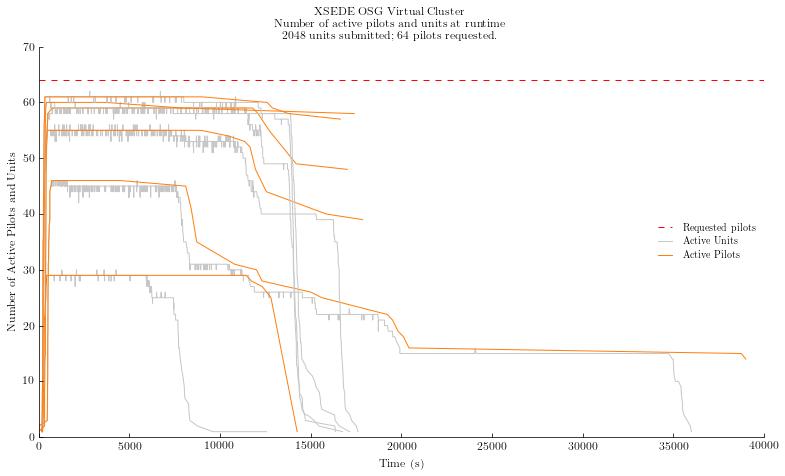

In [78]:
fig, ax = fig_setup()

title='XSEDE OSG Virtual Cluster\n'+\
'Number of active pilots and units at runtime\n'+\
'2048 units submitted; 64 pilots requested.'
fig.suptitle(title)

ax.axhline(64, color='r', linestyle='dashed', linewidth=1)

for s1 in sras[64]:
    # Broken session: open ticket.
    if s1._sid == 'rp.session.radical.mturilli.017131.0005' or \
       s1._sid == 'rp.session.radical.mturilli.017212.0011' or \
       s1._sid == 'rp.session.radical.mturilli.017223.0000' or \
       s1._sid == 'rp.session.radical.mturilli.017228.0001' or \
       s1._sid == 'rp.session.radical.mturilli.017229.0003':
            continue
    
    # Plot concurrent active units
    scu = s1.concurrency(state=['AGENT_EXECUTING', 'AGENT_STAGING_OUTPUT_PENDING'])
    x = [item[0] for item in scu]
    y = [item[1] for item in scu]
    ax.plot(x, y, color=tableau20[23])
    
    # Plot concurrent active pilots
    scp = s1.concurrency(state=['PMGR_ACTIVE', ['DONE', 'CANCELED', 'FAILED']])
    x = [item[0] for item in scp]
    y = [item[1] for item in scp]
    ax.plot(x, y, color=tableau20[2])
        
# ax.set_xscale('log', basex=2)
# ax.set_yscale('log', basey=2)
plt.xlabel('Time (s)')
plt.ylabel('Number of Active Pilots and Units')
# ax.set_xlim(0,17000)
# ax.set_ylim(0,130)
ax.legend(labels=['Requested pilots', 'Active Units', 'Active Pilots'], loc=7)

plt.savefig('figures/osg_nactive-concurrent-pilots_64.pdf', dpi=600, bbox_inches='tight')

## Tasks

### Total number of task per resource across all runs

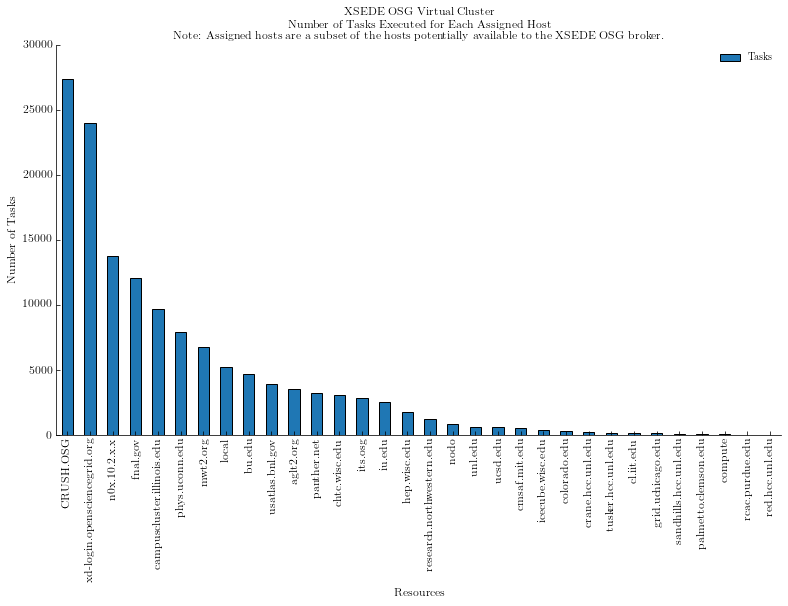

In [79]:
fig, ax = fig_setup()

title='XSEDE OSG Virtual Cluster\nNumber of Tasks Executed for Each Assigned Host\nNote: Assigned hosts are a subset of the hosts potentially available to the XSEDE OSG broker.'

us = units
us[['hid', 'uid']].groupby('hid').count().sort_values(by='uid', ascending=False).plot.bar(ax=ax, color=tableau20[0], title=title)

ax.set_xlabel('Resources')
ax.set_ylabel('Number of Tasks')
ax.legend(labels=['Tasks'])

### Distribution of task execution time ($T_x$) across all runs

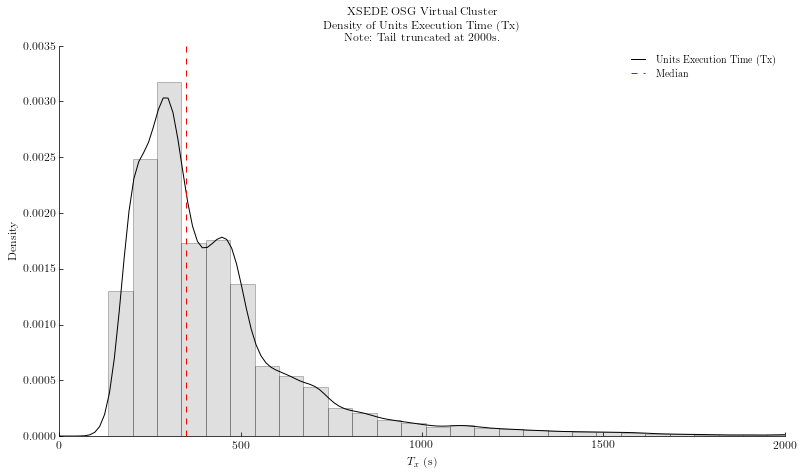

In [80]:
fig, ax = fig_setup()
title='XSEDE OSG Virtual Cluster\nDensity of Units Execution Time (Tx)\nNote: Tail truncated at 2000s.'

units[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.hist(ax=ax, 
                                                                       color='gray', 
                                                                       bins=100, 
                                                                       alpha = 0.25,
                                                                       normed=True)
units[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.density(ax=ax, 
                                                                          color='black', 
                                                                          title=title)
plt.axvline(units['U_AGENT_EXECUTING'].dropna().median(), color='r', linestyle='dashed', linewidth=1)

ax.set_xlim(0, 2000)
ax.set_xlabel('$T_x$ (s)')
ax.legend(labels=['Units Execution Time (Tx)', 'Median'])

plt.savefig('figures/osg_dstrb_tx_all.pdf', dpi=600, bbox_inches='tight')

### Distribution of task execution time ($T_x$) per resource across all runs

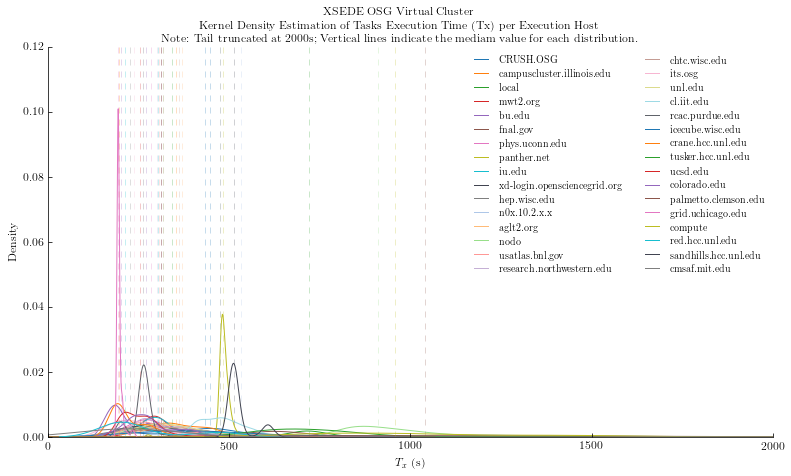

In [81]:
fig, ax = fig_setup()

colors=[tableau20[0] , tableau20[2] , tableau20[4] , tableau20[6] , tableau20[8] , 
        tableau20[10], tableau20[12], tableau20[14], tableau20[16], tableau20[18], 
        tableau20[20], tableau20[1] , tableau20[3] , tableau20[5] , tableau20[7] , 
        tableau20[9] , tableau20[11], tableau20[13], tableau20[15], tableau20[17],
        tableau20[19], tableau20[0] , tableau20[2] , tableau20[4] , tableau20[6] , 
        tableau20[8] , tableau20[10], tableau20[12], tableau20[14], tableau20[16], 
        tableau20[18], tableau20[20], tableau20[1] , tableau20[3] , tableau20[5]]

title='XSEDE OSG Virtual Cluster\nKernel Density Estimation of Tasks Execution Time (Tx) per Execution Host\nNote: Tail truncated at 2000s; Vertical lines indicate the mediam value for each distribution.'
fig.suptitle(title)

hosts = units.loc[units['U_AGENT_EXECUTING'].notnull()]['hid'].dropna().unique()
for host in hosts:
    color = colors.pop(0)
    txs = units.loc[(units['U_AGENT_EXECUTING'].notnull())&(units['hid']==host)][['U_AGENT_EXECUTING']].dropna() 
    txs.reset_index(drop=True).rename(
                index=str, 
                columns={'U_AGENT_EXECUTING': host}).plot.density(ax=ax, color=color)
    plt.axvline(txs['U_AGENT_EXECUTING'].median(), 
                color=color, 
                linestyle='dashed', 
                linewidth=0.5,
                alpha=0.5)

ax.legend(ncol=2)
ax.set_xlim((0, 2000))
ax.set_xlim((0))
ax.set_xlabel('$T_x$ (s)')

plt.savefig('figures/osg_dstrb_tx_x_resource.pdf', dpi=600, bbox_inches='tight')

### Correlation between number of requested tasks/successfully executed tasks

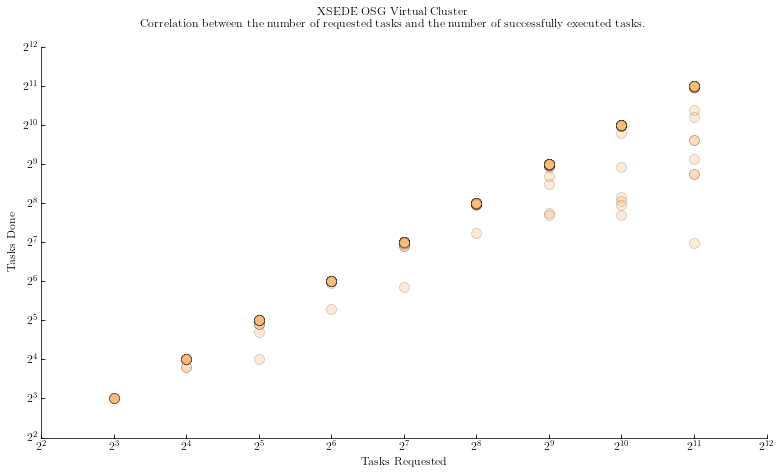

In [82]:
fig, ax = fig_setup()

title='XSEDE OSG Virtual Cluster\n'+\
'Correlation between the number of requested tasks and the number of successfully executed tasks.'
fig.suptitle(title)

ax.scatter(sessions['nunit_requested'], 
           sessions['nunit_done'], 
           s=100, 
           facecolor=tableau20[3], 
           alpha=0.3, 
           lw=0.5)

ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)
plt.xlabel('Tasks Requested')
plt.ylabel('Tasks Done')

### Correlations number of tasks done/rescheduled

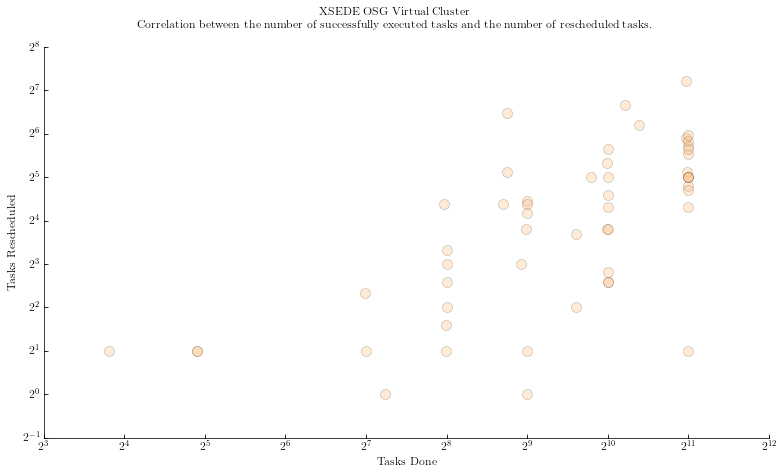

In [83]:
fig, ax = fig_setup()

title='XSEDE OSG Virtual Cluster\n'+\
'Correlation between the number of successfully executed tasks and the number of rescheduled tasks.'
fig.suptitle(title)

qui = sessions.copy()
ax.scatter(qui[qui.nunit_rescheduled > 0]['nunit_done'], 
           qui[qui.nunit_rescheduled > 0]['nunit_rescheduled'], 
           s=100, facecolor=tableau20[3], alpha=0.3, lw=0.5)

ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)
plt.xlabel('Tasks Done')
plt.ylabel('Tasks Rescheduled')